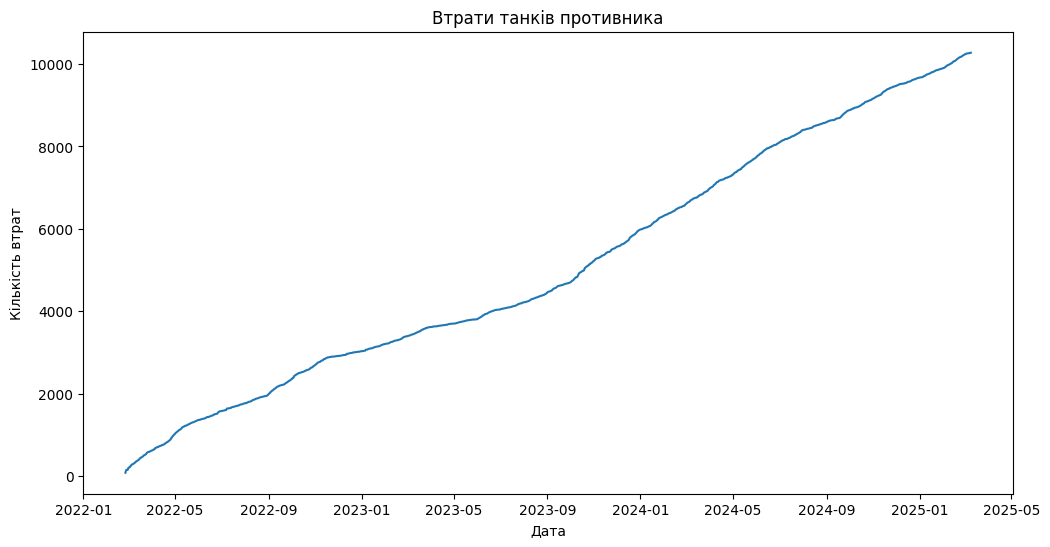

c:\Users\mykro\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  self._init_dates(dates, freq)
c:\Users\mykro\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\mykro\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  self._init_dates(dates, freq)
c:\Users\mykro\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Use

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
MAE ARIMA: 666.58
MAE LSTM: 11.86


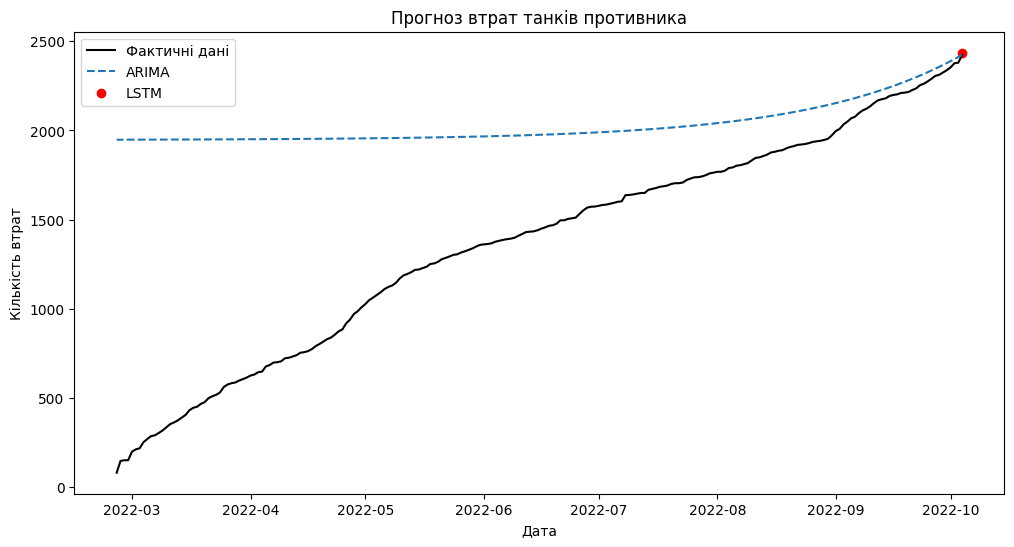

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.optimizers import Adam

# Завантаження даних
data_path = 'russia_losses_equipment.csv'
df = pd.read_csv(data_path)

# Вибір тільки даних про втрати танків
if 'tank' in df.columns:
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df = df[['tank']]
else:
    raise ValueError("Файл не містить колонки 'tank'")

# Візуалізація даних
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x=df.index, y='tank')
plt.title("Втрати танків противника")
plt.xlabel("Дата")
plt.ylabel("Кількість втрат")
plt.show()

# Розділення даних на тренувальний і тестовий набори
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# ARIMA
arima_model = ARIMA(train, order=(5,1,0))
arima_result = arima_model.fit()
arima_pred = arima_result.forecast(steps=len(test))

# ETS (Exponential Smoothing)
# ets_model = ExponentialSmoothing(train, trend='add', seasonal=None).fit()
# ets_pred = ets_model.forecast(steps=len(test))

# LSTM
look_back = 5
train_gen = TimeseriesGenerator(train.values, train.values, length=look_back, batch_size=1)

lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(look_back, 1)),
    Dense(1)
])
lstm_model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
lstm_model.fit(train_gen, epochs=20, verbose=0)

# Підготовка тестових даних для LSTM
X_test = np.array([train.values[-look_back:].flatten()])
X_test = X_test.reshape((1, look_back, 1))
lstm_pred = lstm_model.predict(X_test)

# Оцінка моделей
mae_arima = mean_absolute_error(test, arima_pred)
# mae_ets = mean_absolute_error(test, ets_pred)
mae_lstm = mean_absolute_error(test.iloc[:1], lstm_pred.flatten())

print(f'MAE ARIMA: {mae_arima:.2f}')
# print(f'MAE ETS: {mae_ets:.2f}')
print(f'MAE LSTM: {mae_lstm:.2f}')

# Візуалізація прогнозів
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Фактичні дані', color='black')
plt.plot(test.index, arima_pred, label='ARIMA', linestyle='dashed')
# plt.plot(test.index, ets_pred, label='ETS', linestyle='dotted')
plt.scatter(test.index[:1], lstm_pred.flatten(), label='LSTM', color='red')
plt.legend()
plt.title("Прогноз втрат танків противника")
plt.xlabel("Дата")
plt.ylabel("Кількість втрат")
plt.show()


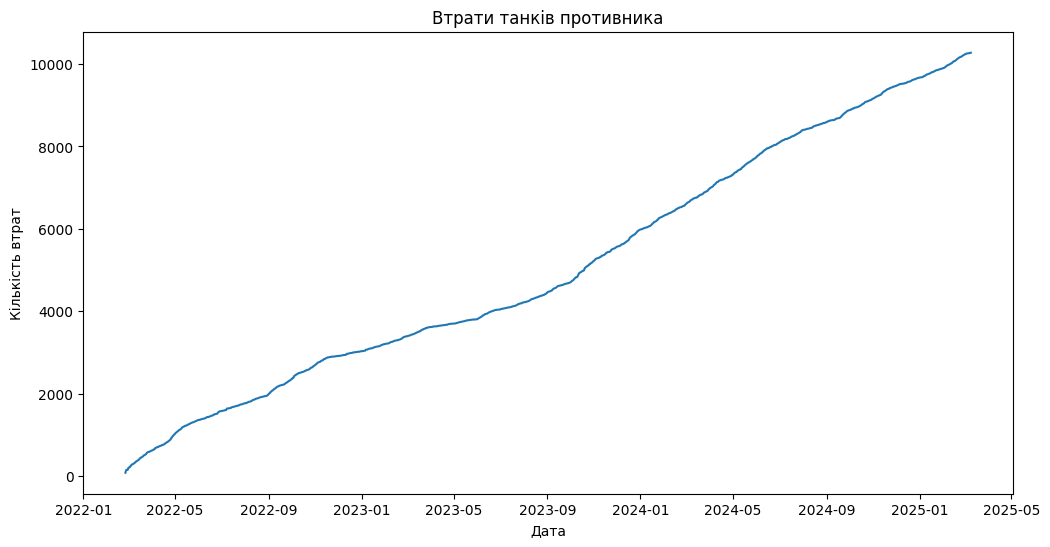

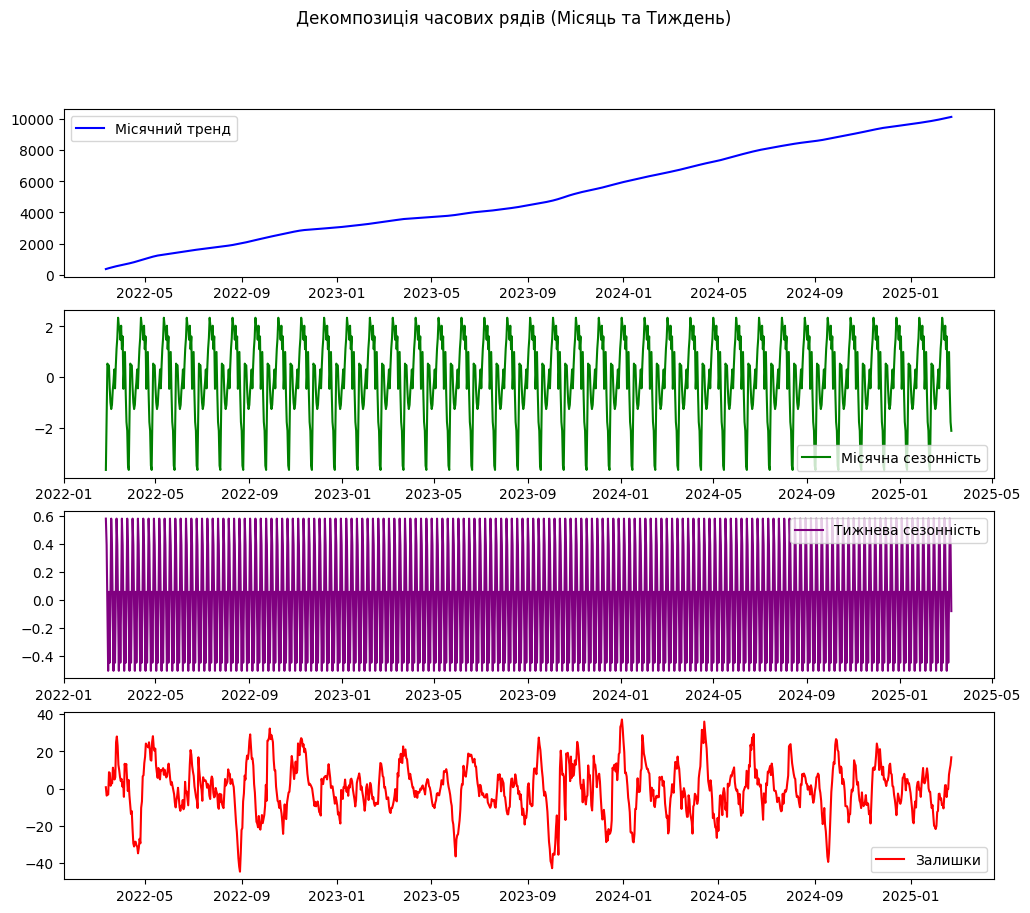

In [4]:
# Візуалізація даних
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x=df.index, y='tank')
plt.title("Втрати танків противника")
plt.xlabel("Дата")
plt.ylabel("Кількість втрат")
plt.show()

# Аналіз трендів
from statsmodels.tsa.seasonal import seasonal_decompose
result_month = seasonal_decompose(df, model='additive', period=30)
result_week = seasonal_decompose(df, model='additive', period=7)

plt.figure(figsize=(12, 10))
plt.subplot(4, 1, 1)
plt.plot(result_month.trend, label='Місячний тренд', color='blue')
plt.legend()
plt.subplot(4, 1, 2)
plt.plot(result_month.seasonal, label='Місячна сезонність', color='green')
plt.legend()
plt.subplot(4, 1, 3)
plt.plot(result_week.seasonal, label='Тижнева сезонність', color='purple')
plt.legend()
plt.subplot(4, 1, 4)
plt.plot(result_month.resid, label='Залишки', color='red')
plt.legend()
plt.suptitle("Декомпозиція часових рядів (Місяць та Тиждень)")
plt.show()
